In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import librosa
import numpy as np
import xml.etree.ElementTree as ET

In [33]:
class MiviaDataset(torch.utils.data.Dataset):
    def __init__(self, mivia_path, max_frames = 60, fs = 16000, partition = ['A'], hop_length = 128, net_pooling = 1):
        self.mivia_path = mivia_path
        self.max_frames = max_frames
        self.partition = partition
        self.fs = fs

        xml_list = []
        for partition in self.partition:
            xml_list += glob.glob(f"{self.mivia_path}/audio/{partition}/*.xml")

        self.xml_files = xml_list

        ## for label encoding
        n_samples = self.max_frames * self.fs
        self.hop_length = hop_length
        self.net_pooling = net_pooling
        self.n_frames = int(int((n_samples/ self.hop_length)) / self.net_pooling)


    def _time_to_frame(self, time):
        samples = time * self.fs
        frame = (samples) / self.hop_length
        return np.clip(frame / self.net_pooling, a_min=0, a_max=self.n_frames)
    
    def _encoder_strong_label(self, xml_dir):
        """Encode a list of strong label"""
        xml = ET.parse(xml_dir)
        root = xml.getroot()

        item = root.find("events").findall("item")

        onset = [float(x.findtext("STARTSECOND")) for x in item] # list, str
        offset = [float(x.findtext("ENDSECOND")) for x in item]  # list, str
        label_idx = [int(x.findtext("CLASS_ID")) for x in item] 

        target = np.zeros([self.n_frames, 2], dtype = 'float32')  # shape : [frame, class], class : 3

        if (len(onset) != len(offset)): 
            print("wrong")
        else:
            for i in range(len(onset)):
                start = int(self._time_to_frame(onset[i])) #버림 -> 해당 time frame에 걸쳐있으면 true??
                end = int(np.ceil(self._time_to_frame(offset[i])))   #올림 -> 해당 time frame에 걸쳐있으면 true
                target[start:end, (label_idx[i]-2)] = 1 # (class_id[i]-1) = 1 : scream, 2 : tire skidding, 3 : car crash
        return (target)
    
    def __len__(self):
        return len(self.xml_files)
    
    def __getitem__(self, idx):
        target = self._encoder_strong_label(self.xml_files[idx])
        print(self.xml_files[idx])
        print(self.xml_files[idx].split('/')[-2])
        partition = self.xml_files[idx].split('/')[-2]
        audio_path = self.xml_files[idx].replace('.xml', '_1.wav').replace(f'/{partition}/', f'/{partition}/v2/')
        audio_data, _ = librosa.load(audio_path, mono = True, sr = self.fs)

        return audio_data, target
    
import matplotlib.pyplot as plt

def draw_heatmap(data, sampling_frequency, hop_length):
    plt.figure(figsize=(10, 6)) # Figure size can be adjusted according to your preference
    plt.imshow(data, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar()  # Optional: if you want a colorbar to indicate the values
    
    x_ticks = np.arange(0, data.shape[1], step=5*sampling_frequency/hop_length)
    plt.xticks(x_ticks, x_ticks * (hop_length / sampling_frequency))
    plt.xlabel("Time (s)")
    
    plt.yticks([0, 1], ['tire', 'crash'])
    plt.show()




In [34]:
PARTITION = ['A', 'B']
MAX_FRAMES = 60
MIVIA_PATH = './data/mivia_raw/'



In [35]:
train_dataset = MiviaDataset(MIVIA_PATH, MAX_FRAMES, partition = PARTITION)

In [36]:
data, label = train_dataset[1]

./data/mivia_raw//audio/A/00007.xml
A


In [23]:
data.shape

(1042967,)

In [13]:
label.shape

(7500, 2)

In [14]:
type(label)

numpy.ndarray

In [15]:
draw_heatmap(label.T)

TypeError: draw_heatmap() missing 2 required positional arguments: 'sampling_frequency' and 'hop_length'

In [16]:
label.shape

(7500, 2)

In [17]:
def draw_heatmap(data, sampling_frequency, hop_length):
    plt.figure(figsize=(10, 6)) # Figure size can be adjusted according to your preference
    plt.imshow(data, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar()  # Optional: if you want a colorbar to indicate the values
    
    x_ticks = np.arange(0, data.shape[1], step=5*sampling_frequency/hop_length)
    plt.xticks(x_ticks, x_ticks * (hop_length / sampling_frequency))
    plt.xlabel("Time (s)")
    
    plt.yticks([0, 1], ['tire', 'crash'])
    plt.show()


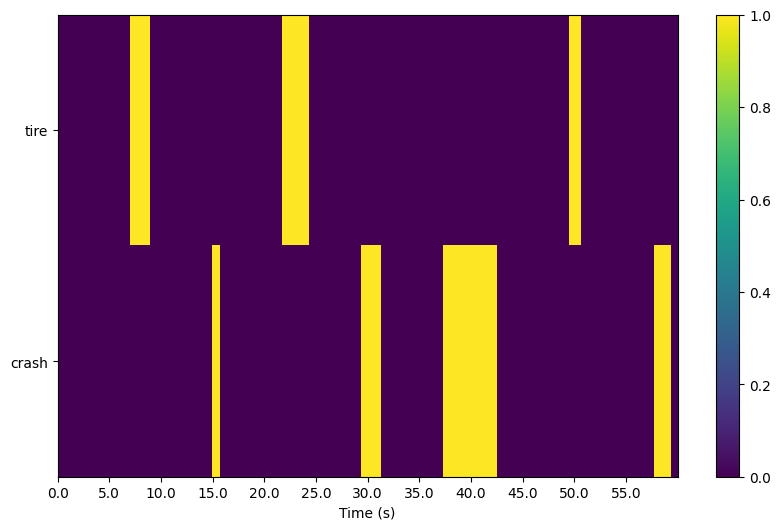

In [18]:
draw_heatmap(label.T, 16000, 128)